In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')
dpath='D:/zhenqiyuce//'

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import Imputer

In [158]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor,BaggingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

In [4]:
import numpy as np
from scipy.stats import pearsonr

In [5]:
from sklearn.feature_selection import VarianceThreshold

In [38]:
import seaborn as sns
%matplotlib inline

In [6]:
pd.set_option('max_colwidth',200)
pd.set_option('display.width',200)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',1000)

In [7]:
train=pd.read_table(dpath+'zhengqi_train.txt')
test=pd.read_table(dpath+'zhengqi_test.txt')
print(train.shape)
print(test.shape)

(2888, 39)
(1925, 38)


In [10]:
full=pd.concat([train,test], ignore_index=True)
print(full.shape)

(4813, 39)


In [11]:
#看各特征的缺失值数量
aa = full.isnull().sum()
aa[aa>0].sort_values(ascending=False)
#没有缺失值

target    1925
dtype: int64

In [12]:
n_train=train.shape[0]
X = full[:n_train].drop("target",axis=1)
test_X = full[n_train:].drop("target",axis=1)
y= train.target

In [16]:
lasso=Lasso(alpha=0.001)
lasso.fit(X,y) 

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [17]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=X.columns)

,Feature Importance
V0,0.345417
V1,0.188009
V10,0.293780
V11,0.026063
V12,0.095972
V13,-0.001680
V14,0.052831
V15,-0.000000
V16,0.023222
V17,0.084721


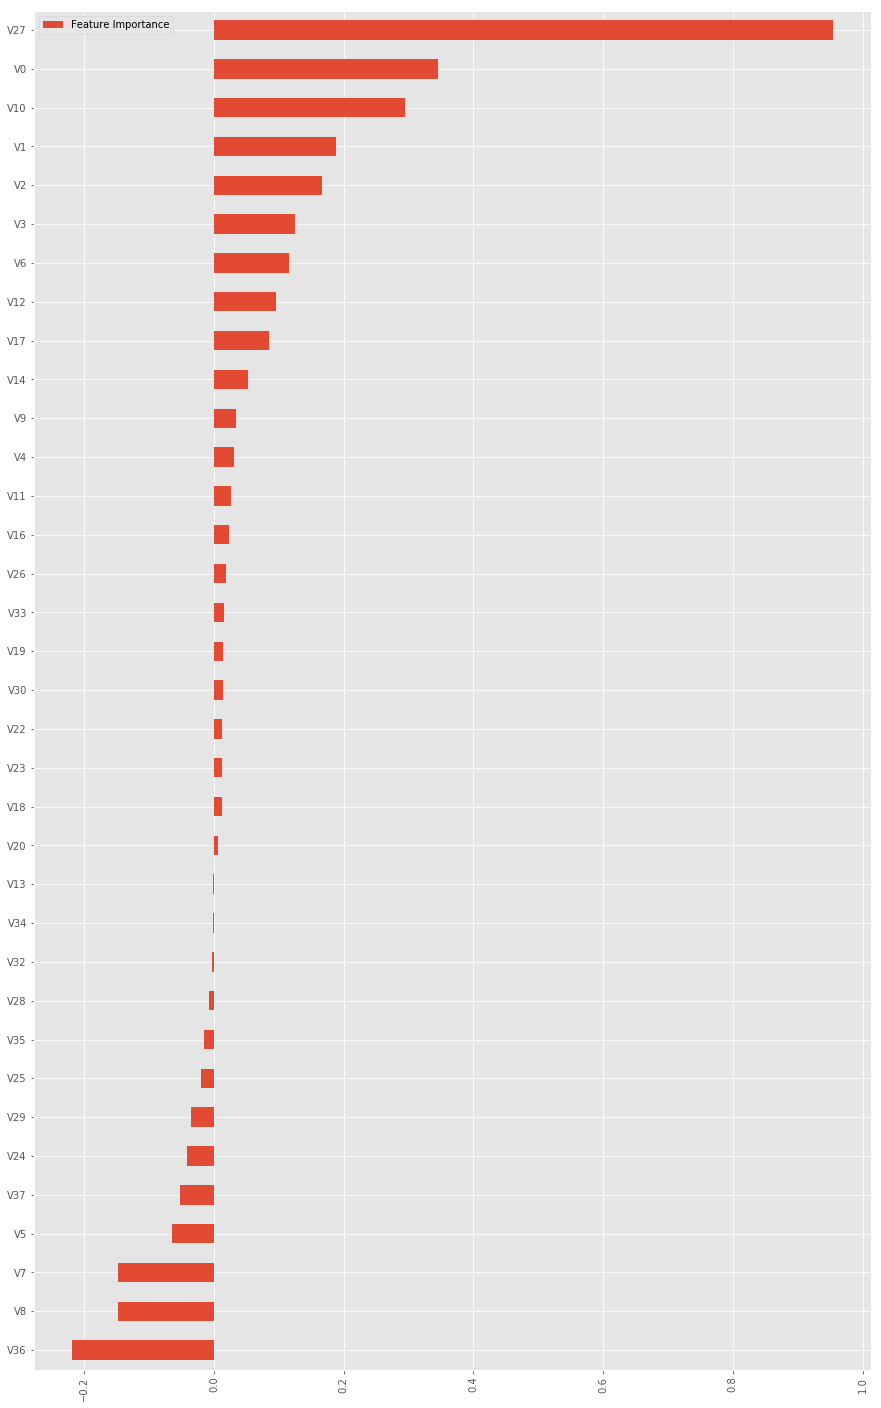

In [18]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

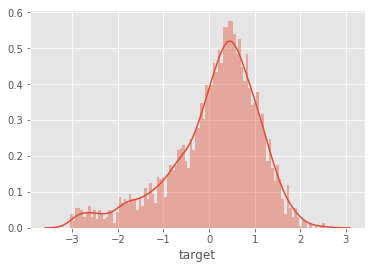

In [43]:
sns.distplot(y,bins=100,kde=True)

<function matplotlib.pyplot.show(*args, **kw)>

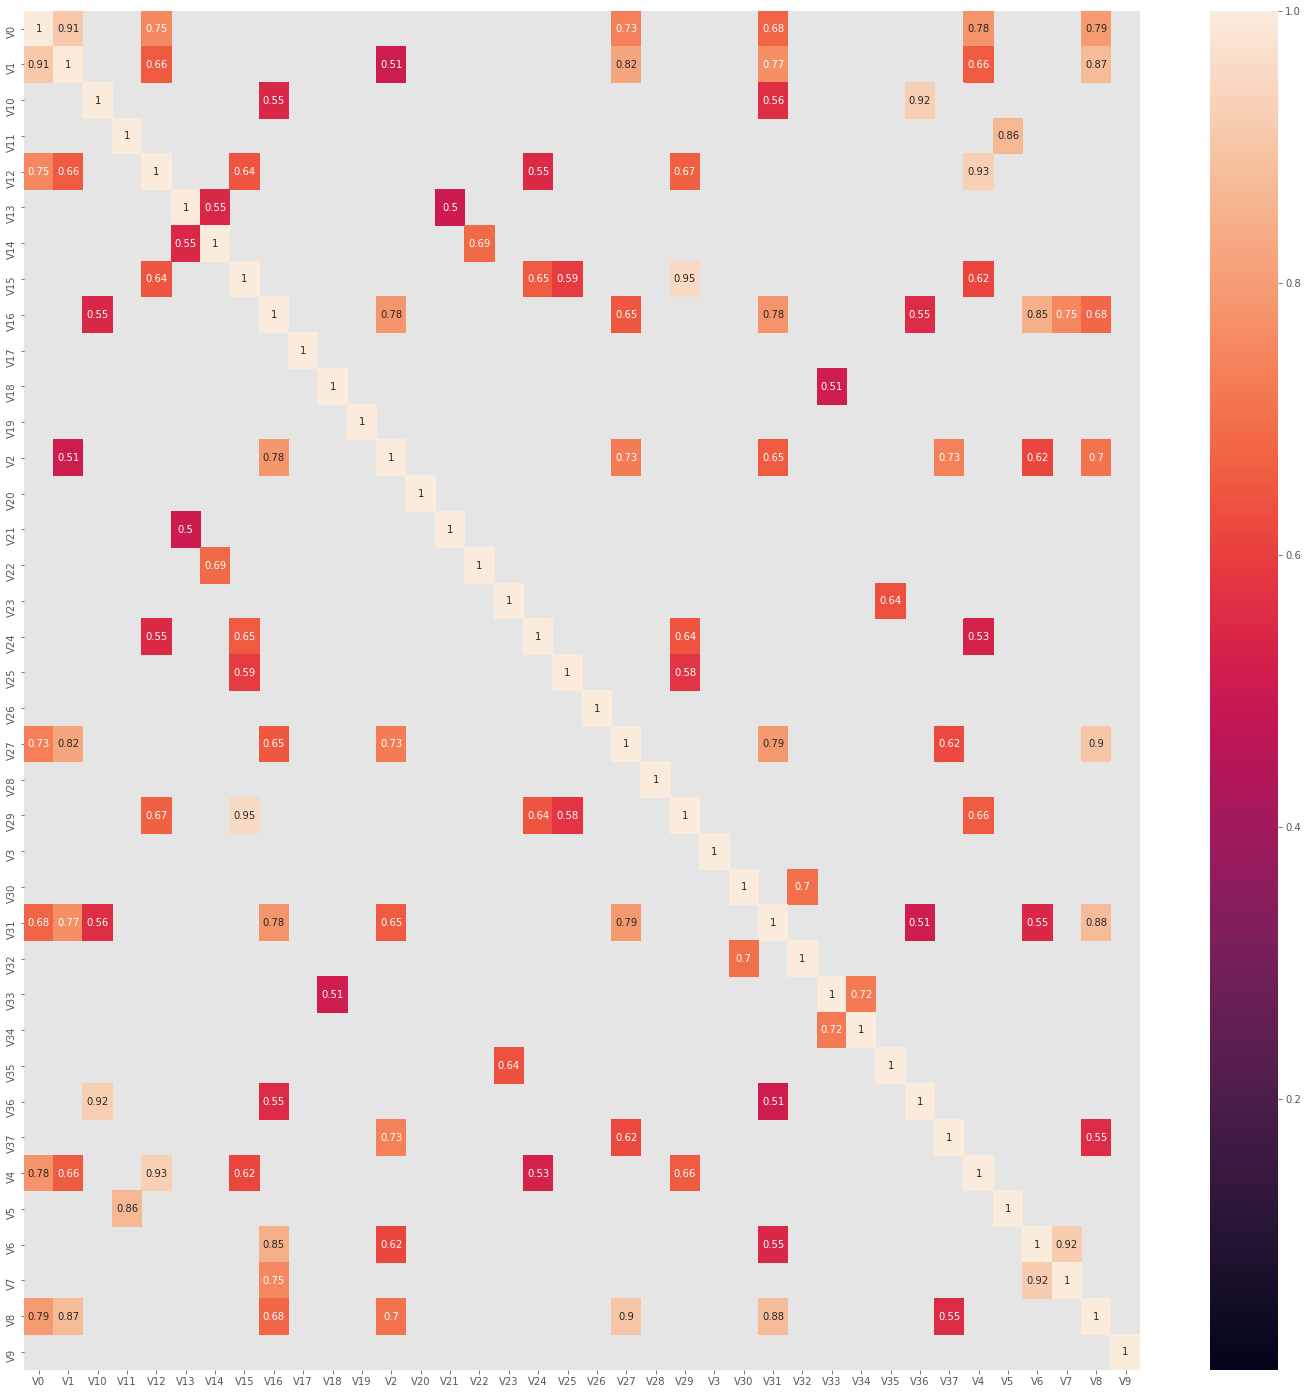

In [57]:
X_corr=X.corr().abs()
plt.subplots(figsize=(25,25))
sns.heatmap(X_corr,annot=True,mask=X_corr<0.5)
plt.show

#pca降维
pca = PCA(n_components=0.95)
X_pca=pca.fit_transform(X)
test_X_pca = pca.transform(test_X)

X_pca.shape, test_X_pca.shape

In [86]:
list(FI_lasso[abs(FI_lasso['Feature Importance'])>0.01].index)

['V0',
 'V1',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'V19',
 'V2',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V29',
 'V3',
 'V30',
 'V33',
 'V35',
 'V36',
 'V37',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9']

In [87]:
X_feature_section=list(FI_lasso[abs(FI_lasso['Feature Importance'])>0.01].index)

In [141]:
pca = PCA(n_components=0.95)
pca.fit(X[X_feature_section])
X_feature_section_pca=pca.transform(X[X_feature_section])
test_X_feature_section_pca = pca.transform(test_X[X_feature_section])

## 基本建模&评估

In [142]:
#定义RMSE的交叉验证评估指标
def mse_cv(model,X,y):
    mse = -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)
    return mse

使用了13个算法和5折交叉验证来评估baseline效果：
LinearRegression                     线性回归
Ridge                                岭回归
Lasso                                Lasso回归
Random Forrest                       随机森林
Gradient Boosting Tree               梯度提升树
Support Vector Regression            支持向量回归
Linear Support Vector Regression     线性支持向量回归
ElasticNet                           
Stochastic Gradient Descent          随机梯度下降
BayesianRidge                        
KernelRidge                          
ExtraTreesRegressor                   
XgBoost                              XGboost

In [176]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor(num_round = 2),BaggingRegressor()]
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb",'Bagging']

In [177]:
for name, model in zip(names, models):
    score = mse_cv(model, X_feature_section_pca,y)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 0.133698, 0.0247
Ridge: 0.133694, 0.0247
Lasso: 0.135302, 0.0228
RF: 0.187791, 0.0286
GBR: 0.153647, 0.0253
SVR: 0.208631, 0.0429
LinSVR: 0.135720, 0.0268
Ela: 0.133633, 0.0246
SGD: 0.133420, 0.0270
Bay: 0.133673, 0.0246
Ker: 0.157053, 0.0347
Extra: 0.190733, 0.0248
Xgb: 0.150705, 0.0240
Bagging: 0.194998, 0.0255


In [145]:
# 调参
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=10, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, -grid_search.best_score_)
        grid_search.cv_results_['mean_test_score'] = -grid_search.cv_results_['mean_test_score']
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [122]:
### Lasso
#grid(Lasso()).grid_get(X,y,{'alpha': [0.04,0.05,0.07],'max_iter':[10000]})

{'alpha': 0.04, 'max_iter': 10000} 0.13897293515469322
                               params  mean_test_score  std_test_score
0  {'alpha': 0.04, 'max_iter': 10000}         0.138973        0.053808
1  {'alpha': 0.05, 'max_iter': 10000}         0.141985        0.055429
2  {'alpha': 0.07, 'max_iter': 10000}         0.147177        0.057570


In [146]:
### Ridge
grid(Ridge()).grid_get(X_feature_section_pca,y,{'alpha':[1,5,10,15,55,60,65,70,80,90]})

{'alpha': 15} 0.13381665859042732
          params  mean_test_score  std_test_score
0   {'alpha': 1}         0.133827        0.052089
1   {'alpha': 5}         0.133823        0.052092
2  {'alpha': 10}         0.133819        0.052096
3  {'alpha': 15}         0.133817        0.052100
4  {'alpha': 55}         0.133840        0.052145
5  {'alpha': 60}         0.133848        0.052152
6  {'alpha': 65}         0.133857        0.052159
7  {'alpha': 70}         0.133868        0.052167
8  {'alpha': 80}         0.133891        0.052183
9  {'alpha': 90}         0.133918        0.052199


In [147]:
### SVR
grid(SVR()).grid_get(X_feature_section_pca,y,{'C':[5.5],'kernel':["rbf"],"gamma":[0.003],"epsilon":[0.069]})

{'C': 5.5, 'epsilon': 0.069, 'gamma': 0.003, 'kernel': 'rbf'} 0.12563597966922224
                                                          params  mean_test_score  std_test_score
0  {'C': 5.5, 'epsilon': 0.069, 'gamma': 0.003, 'kernel': 'rbf'}         0.125636        0.053754


### 
### grid(SVR()).grid_get(X_feature_section_pca,y,{'C':[5,5.5,5.25],'kernel':["rbf"],"gamma":[0.003],"epsilon":[0.068,0.069,0.070]})
   {'C': 5.5, 'epsilon': 0.069, 'gamma': 0.003, 'kernel': 'rbf'} 0.1256359796692221

In [167]:
#由上结果可看到  SVR  参数设置为{'C':[5,5.5,5.25],'kernel':["rbf"],"gamma":[0.003],"epsilon":[0.068,0.069,0.070]} 效果最好
mySVR=SVR(C=5.5,kernel="rbf",gamma=0.003,epsilon=0.069)
mySVR.fit(X_feature_section_pca,y)
y_pred=mySVR.predict(X_feature_section_pca)
print(mean_squared_error(y, y_pred))

0.1048894278960864


In [155]:
test_y_pred = mySVR.predict(test_X_feature_section_pca)

In [157]:
pd.DataFrame(test_y_pred).to_csv('zhenqi_result.txt',index=False, header=False)
#print('over')

In [125]:
### XGB
#grid(XGBRegressor()).grid_get(X_feature_section_pca,y,{'max_depth':[3,4,5], 'eta':[0.03,0.01] ,'n_estimators': [500,600],'min_child_weight': [3,4]})

{'eta': 0.03, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500} 0.14774612780811336
                                                                       params  mean_test_score  std_test_score
0   {'eta': 0.03, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500}         0.147746        0.054160
1   {'eta': 0.03, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 600}         0.149202        0.054743
2   {'eta': 0.03, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 500}         0.148215        0.054188
3   {'eta': 0.03, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 600}         0.148881        0.054616
4   {'eta': 0.03, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 500}         0.155739        0.057511
5   {'eta': 0.03, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 600}         0.156584        0.057444
6   {'eta': 0.03, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 500}         0.154027        0.054728
7   {'eta': 0.03, 

## Bagging

In [174]:
myBag=BaggingRegressor( n_estimators=100, max_samples=0.8, max_features=0.8, bootstrap=True, bootstrap_features=True)

In [175]:
myBag.fit(X_feature_section_pca,y)
y_pred=myBag.predict(X_feature_section_pca)
print(mean_squared_error(y, y_pred))

0.04597708150245845


In [181]:
grid(BaggingRegressor()).grid_get(X_feature_section_pca,y,{'n_estimators':[100,200,300],"max_samples": [ 0.8,0.9], "max_features": [1.0],"bootstrap": [True],"bootstrap_features": [False]})

{'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.9, 'n_estimators': 300} 0.16619446684182823
                                                                                                           params  mean_test_score  std_test_score
0  {'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.8, 'n_estimators': 100}         0.168623        0.066287
1  {'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.8, 'n_estimators': 200}         0.168762        0.066664
2  {'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.8, 'n_estimators': 300}         0.167256        0.065156
3  {'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.9, 'n_estimators': 100}         0.169008        0.066081
4  {'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.9, 'n_estimators': 200}         0.167484    